<a href="https://colab.research.google.com/github/xoelmv/Aprendizaje-Automatico/blob/main/Lab4_Parte_1(Redes_neuronales_usando_Keras_con_Regularizaci%C3%B3n).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eirasf/GCED-AA2/blob/main/lab4/lab4_parte1.ipynb)
# Práctica 4: Redes neuronales usando Keras con Regularización
## Parte 1. Early Stopping
### Overfitting
El problema del sobreajuste (*overfitting*) consiste en que la solución aprendida se ajusta muy bien a los datos de entrenamiento, pero no generaliza adecuadamente ante la aparición de nuevos datos.

# Regularización

Una vez diagnosticado el sobreajuste, es hora de probar diferentes técnicas que intenten reducir la varianza, sin incrementar demasiado el sesgo y, con ello, el modelo generaliza mejor. Las técnicas de regularización que vamos a ver en este laboratorio son:
1. *Early stopping*. Detiene el entrenamiento de la red cuando aumenta el error.
1. Penalización basada	en	la	norma	de	los	parámetros (tanto norma L1 como L2).
1. *Dropout*. Ampliamente utilizada en aprendizaje profundo, "desactiva" algunas neuronas para evitar el sobreajuste.

En esta primera parte del Laboratorio 4 nos centraremos en **Early Stopping**






## Pre-requisitos. Instalar paquetes

Para la primera parte de este Laboratorio 4 necesitaremos TensorFlow, TensorFlow-Datasets y otros paquetes para inicializar la semilla y poder reproducir los resultados

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import random

#Fijamos la semilla para poder reproducir los resultados
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


Además, cargamos también APIs que vamos a emplear para que el código quede más legible

In [2]:
#API de Keras, modelo Sequential y las capas que vamos a usar en nuestro modelo
from tensorflow import keras
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
#Para mostrar gráficas
from matplotlib import pyplot

#Necesario para el EarlyStopping
from keras.callbacks import EarlyStopping


## Cargamos el conjunto de datos

De nuevo, seguimos empleando el conjunto *german_credit_numeric* ya empleado en los laboratorios anteriores, aunque esta vez lo dividimos para tener un subconjunto de entrenamiento, otro de validación (que nos servirá para detener el entrenamiento) y otro de test para evaluar el rendimiento del modelo.


In [3]:
# Cargamos el conjunto de datos
ds_train = tfds.load('german_credit_numeric', split='train[:40%]',  as_supervised=True).batch(128)
ds_val = tfds.load('german_credit_numeric', split='train[40%:50%]', as_supervised=True).batch(128)
ds_test = tfds.load('german_credit_numeric', split='train[50%:]', as_supervised=True).batch(128)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/german_credit_numeric/incomplete.2HAFCF_1.0.0/german_credit_numeric-train.…

Dataset german_credit_numeric downloaded and prepared to /root/tensorflow_datasets/german_credit_numeric/1.0.0. Subsequent calls will reuse this data.


También vamos a establecer la función de pérdida, el algoritmo que vamos a emplear para el entrenamiento y la métrica que nos servirá para evaluar el rendimiento del modelo entrenado.

In [4]:
#Indicamos la función de perdida, el algoritmo de optimización y la métrica para evaluar el rendimiento
fn_perdida = tf.keras.losses.BinaryCrossentropy()
optimizador = tf.keras.optimizers.Adam(learning_rate=0.001)
metrica = tf.keras.metrics.AUC()

## Creamos un modelo *Sequential*
Creamos un modelo *Sequential* tal y como se ha hecho en el Laboratorio 3. Parte 2.

In [5]:
tamano_entrada = 24
h0_size = 5
h1_size = 3
#TODO - define el modelo indicando un nombre
model =  tf.keras.models.Sequential(name="Model")

model.add( tf.keras.layers.InputLayer((tamano_entrada,)))
#TODO - incluye las 3 capas Dense al modelo
model.add(tf.keras.layers.Dense(h0_size, activation="sigmoid"))
model.add(tf.keras.layers.Dense(h1_size, activation="sigmoid"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

#Se construye el modelo y se muestra
model.build()
print(model.summary())

Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │           125 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147 (588.00 B)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 0 (0.00 B)

None


Completar el método *compile*.

In [6]:
#TODO - indicar los parametros del método compile
model.compile(loss=fn_perdida,
              optimizer=optimizador,
              metrics=[metrica])

Hacemos una llamada al método *fit* usando el conjunto de entrenamiento como entrada, indicando el número de epochs y, además,  incluyendo el argumento *validation_data* que permite usar un subconjunto de datos para validar. Las diferencias entre entrenamiento y validación se pueden apreciar en el gráfico.

**NOTA**: Observad las diferencias de resultado entre entrenamiento, validación y test.

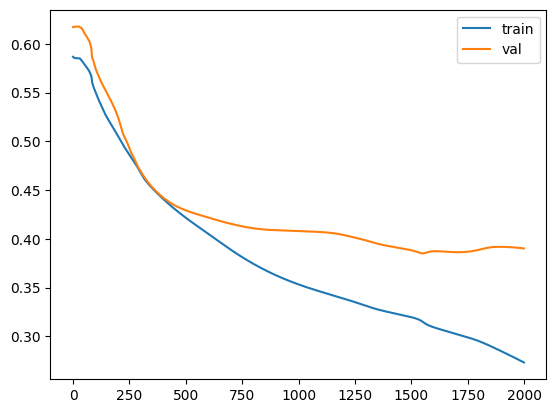

In [7]:
#Establecemos el número de epochs
num_epochs =  2000

# Guardamos los pesos antes de entrenar, para poder resetear el modelo posteriormente y hacer comparativas.
pesos_preentrenamiento = model.get_weights()

#TODO - entrenar el modelo usando como entradas el conjunto de entrenamiento,
#indicando el número de epochs y el conjunto de validación
history = model.fit(ds_train, validation_data=ds_val, epochs=num_epochs, verbose=0)

# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [8]:
#TODO - llamar a evaluate usando el conjunto de test, guardando el resultado
result = model.evaluate(ds_test)
print(model.metrics_names)
print(result)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.7582 - loss: 0.6611 
['loss', 'compile_metrics']
[0.7042971849441528, 0.7490959763526917]


## Usando Early Stopping en el entrenamiento

Keras nos facilita un *Callback* para realizar la parada temprana (*keras.callbacks.EarlyStopping*).  De este modo, podemos parar el entrenamiento cuando una determinada medida (especificada en el argumento *monitor*) empeore su rendimiento (el argumento *mode* nos dirá si se espera que dicha medida se minimice, *min*, o maximice, *max*). Opcionalmente, el usuario puede proporcionar el argumento *patience* para especificar cuantas *epochs* debe esperar el entrenamiento antes de detenerse.

**TO-DO**: Realizar varias veces el entrenamiento, cambiando los distintos parámetros para ver las diferencias en el aprendizaje. ¿Se para siempre en el mismo *epoch*? Comprobar el rendimiento en el conjunto de test.

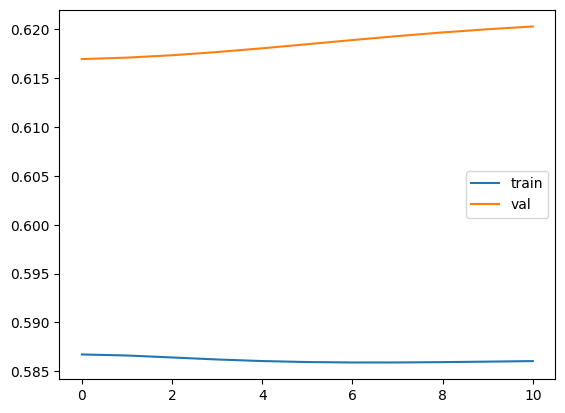

In [9]:
# simple early stopping
#TODO- indica la medida a monitorizar,  el modo y la paciencia

es = EarlyStopping(
    monitor='val_loss',  # lo que queremos controlar
    patience=10,         # número de epochs sin mejora antes de parar
    restore_best_weights=True  # volver a los mejores pesos
)


# Antes de entrenar, olvidamos el entrenamiento anterior restaurando los pesos iniciales
model.set_weights(pesos_preentrenamiento)

#TODO - entrenar el modelo usando como entradas el conjunto de entrenamiento,
#indicando el número de epochs, el conjunto de validación y la callback para el EarlyStopping
history = model.fit(ds_train, validation_data=ds_val, epochs=num_epochs, callbacks=[es], verbose=0)

# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

Evaluación sobre el conjunto de test (no usado para el entrenamiento).

In [10]:
#TODO - llamar a evaluate usando el conjunto de test, guardando el resultado
result = model.evaluate(ds_test)
print(model.metrics_names)
print(result)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.4792 - loss: 0.6219
['loss', 'compile_metrics']
[0.6357668042182922, 0.46425962448120117]


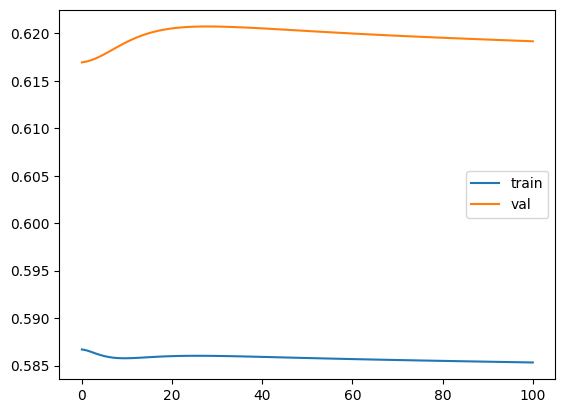

In [12]:
# aumentamos patience
es = EarlyStopping(
    monitor='val_loss',  # lo que queremos controlar
    patience=100,         # número de epochs sin mejora antes de parar
    restore_best_weights=True  # volver a los mejores pesos
)


# Antes de entrenar, olvidamos el entrenamiento anterior restaurando los pesos iniciales
model.set_weights(pesos_preentrenamiento)

#TODO - entrenar el modelo usando como entradas el conjunto de entrenamiento,
#indicando el número de epochs, el conjunto de validación y la callback para el EarlyStopping
history = model.fit(ds_train, validation_data=ds_val, epochs=num_epochs, callbacks=[es], verbose=0)

# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [13]:
#TODO - llamar a evaluate usando el conjunto de test, guardando el resultado
result = model.evaluate(ds_test)
print(model.metrics_names)
print(result)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - auc: 0.4889 - loss: 0.6218
['loss', 'compile_metrics']
[0.6356893181800842, 0.47040504217147827]


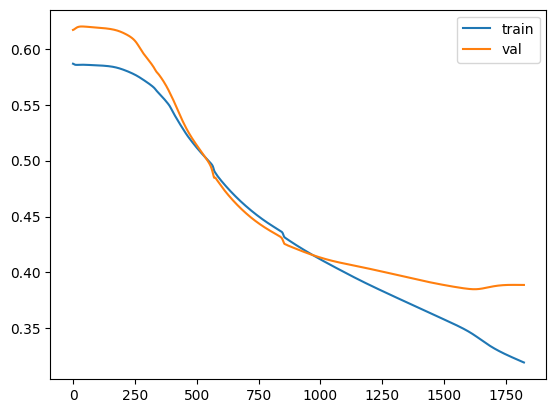

In [15]:
# aumentamos patience
es = EarlyStopping(
    monitor='val_loss',  # lo que queremos controlar
    patience=200,         # número de epochs sin mejora antes de parar
    restore_best_weights=True  # volver a los mejores pesos
)


# Antes de entrenar, olvidamos el entrenamiento anterior restaurando los pesos iniciales
model.set_weights(pesos_preentrenamiento)

#TODO - entrenar el modelo usando como entradas el conjunto de entrenamiento,
#indicando el número de epochs, el conjunto de validación y la callback para el EarlyStopping
history = model.fit(ds_train, validation_data=ds_val, epochs=num_epochs, callbacks=[es], verbose=0)

# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [16]:
#TODO - llamar a evaluate usando el conjunto de test, guardando el resultado
result = model.evaluate(ds_test)
print(model.metrics_names)
print(result)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.7758 - loss: 0.5776 
['loss', 'compile_metrics']
[0.6270659565925598, 0.753871738910675]


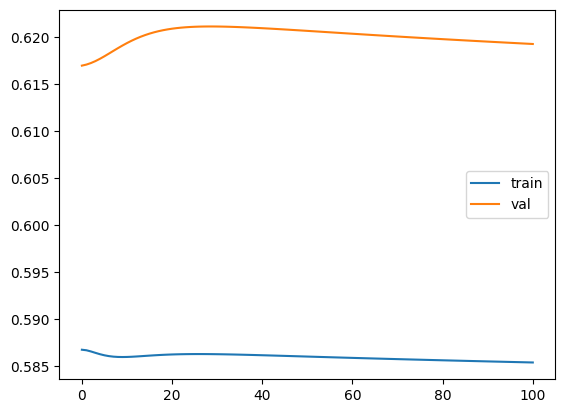

In [17]:
# aumentamos patience
es = EarlyStopping(
    monitor='val_loss',  # lo que queremos controlar
    patience=100,         # número de epochs sin mejora antes de parar
    restore_best_weights=True  # volver a los mejores pesos
)


# Antes de entrenar, olvidamos el entrenamiento anterior restaurando los pesos iniciales
model.set_weights(pesos_preentrenamiento)

#TODO - entrenar el modelo usando como entradas el conjunto de entrenamiento,
#indicando el número de epochs, el conjunto de validación y la callback para el EarlyStopping
history = model.fit(ds_train, validation_data=ds_val, epochs=num_epochs, callbacks=[es], verbose=0)

# plot training history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [18]:
#TODO - llamar a evaluate usando el conjunto de test, guardando el resultado
result = model.evaluate(ds_test)
print(model.metrics_names)
print(result)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.4889 - loss: 0.6218 
['loss', 'compile_metrics']
[0.635682225227356, 0.473929762840271]
